In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2024-12-10 14:33:08.183233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733841188.490833   16586 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733841188.558610   16586 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 14:33:09.227702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path to dataset containing 9 folders (one for each class)
dataset_path = "data"

# Load dataset and split it
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 4752 files belonging to 9 classes.


2024-12-10 14:33:42.175411: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Split into train (70%), validation (20%), and test (10%)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)
test_data = dataset.skip(train_size + val_size)

In [4]:
# Prefetch data for performance
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [6]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(len(dataset.class_names), activation='softmax')(x)

In [7]:
# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Model training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

Epoch 1/10


2024-12-10 14:36:45.868327: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-10 14:36:46.133281: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20313600 exceeds 10% of free system memory.
2024-12-10 14:36:46.147237: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-12-10 14:36:46.200239: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-12-10 14:36:46.530304: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


104/104 ━━━━━━━━━━━━━━━━━━━━ 472s 4s/step - accuracy: 0.5622 - loss: 1.3394 - val_accuracy: 0.7619 - val_loss: 0.7206
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.8248 - loss: 0.5224 - val_accuracy: 0.7931 - val_loss: 0.5792
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.8817 - loss: 0.3313 - val_accuracy: 0.8125 - val_loss: 0.5729
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9272 - loss: 0.2145 - val_accuracy: 0.8308 - val_loss: 0.5424
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9532 - loss: 0.1508 - val_accuracy: 0.8233 - val_loss: 0.5422
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9572 - loss: 0.1238 - val_accuracy: 0.8459 - val_loss: 0.5312
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.9837 - loss: 0.0639 - val_accuracy: 0.8664 - val_loss: 0.4527
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.9929 - loss: 0.0379 - val_accuracy: 0.881

In [10]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8925 - loss: 0.3995
Test Accuracy: 0.87


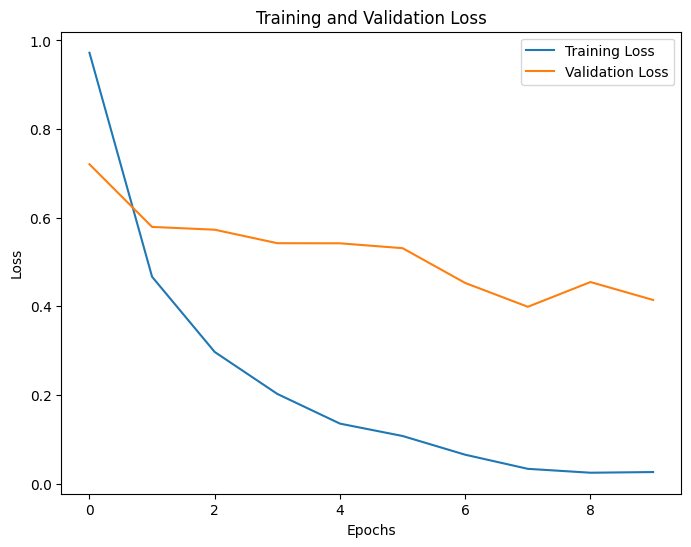

In [11]:
# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Comparison.

When comparing this model to our custom model, it can be clearly seen that for 10 epochs;
Custom model ,
Accuracy = 0.7977 
Loss = 0.5781

for ResNet model,
Accuracy = 0.9975
Loss = 0.0288

By comparing above data it can be clearly seen that the Resnet model has a significantly high Accuracy with a small Loss compared to the custom model.

Talking about training and validation losses,
Training losses significantly decreases when epoch value increase. Validation loss also decreases but not as significantly as Training loss.


Both the models have their own advantages and disadvantages

A custom model is very well used for unique tasks and data which aren't common or cannot be generalized. But training an data collection gives the devlopers much more hard time.

An established model on the other hand can be great for much more generalized tasks and for small data sets. The main disadvantage is that they cn carry unnesecery feature overheads which aren't necessary for the task at hand.


Trade-offs

Accuracy vs. Resource Efficiency: Custom models might achieve slightly higher accuracy on highly specific tasks but require more resources to train. Pre-trained models are often faster but may sacrifice some task-specific accuracy.

Time vs. Flexibility: Custom models offer more flexibility but take longer to design and train, while pre-trained models are quick to implement but less adaptable.

Generalization vs. Overfitting: Pre-trained models excel at generalization on small datasets, whereas custom models can overfit unless carefully regularized or trained with sufficient data.
